In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
from random import sample
import math
import pickle as pk
from collections import Counter
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from random import sample
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc

In [2]:
def cv_exp_perform(feature_arr, label_arr, clf):
    k_fold = KFold(10, shuffle=True)
    res_pre_list = []
    res_label_list = []
    mean_fpr = np.linspace(0, 1, 200)
    
    print('cv start')
    # perform 10-fold cv
    for k, (train_idx, test_idx) in enumerate(k_fold.split(label_arr)):
        train_x, train_y = feature_arr[train_idx], label_arr[train_idx]
        test_x, test_y = feature_arr[test_idx], label_arr[test_idx]

        clf.fit(train_x, train_y)
        res_pre_list.append(clf.predict_proba(test_x)[:,1])
        res_label_list.append(test_y)

    # combine result
    pre_res = np.concatenate(res_pre_list)
    label_arr_res = np.concatenate(res_label_list)
    
    fpr_t, tpr_t, thresh_t = metrics.roc_curve(label_arr_res, pre_res)
    mean_tpr = np.interp(mean_fpr, fpr_t, tpr_t)
    mean_tpr[0] = 0.0

    mean_auc = auc(mean_fpr, mean_tpr)
    mean_fpr_100 = mean_fpr * 100
    mean_tpr_100 = mean_tpr * 100
    
    i_1, = np.where(mean_fpr_100>=1.0)
    y_1 = mean_tpr_100[i_1[0]]
    
    roc_res_dict = {
            "mean_fpr_100": mean_fpr_100,
            "mean_tpr_100": mean_tpr_100,
            "mean_auc": mean_auc,
            "i_1": i_1,
            "y_1": y_1
            }

    return roc_res_dict

## Leave one feature set out

In [5]:
# feature selection dict
feature_path = '../data/feature'
feat_sel_dict = {'pnp': ['bk_feature.txt', 'wh_feature.txt'],
                'bk':  ['pnp_feature.txt', 'wh_feature.txt'],
                'wh':  ['pnp_feature.txt', 'bk_feature.txt']}

In [6]:
f_tr = '../data/TSS_TA_training_data.csv'
result_path = '../temp/exp_res_pkl'

In [20]:
def taser_leave_one_feat_out_cv(f_data, result_path, max_depth_x=1, n_estimators = 500):
    for k, f_list in feat_sel_dict.items():
        feat_list = ['label']
        print(f'leave {k} out:')
        for f in feat_sel_dict[k]:
            fp_feature_name = os.path.join(feature_path, f)
            with open(fp_feature_name, 'r') as fr:
                feature_names = [line.strip() for line in fr if not line.startswith("#")]    
            feat_list += feature_names
        
        df = pd.read_csv(f_tr, usecols=feat_list)
    
        feature_arr = df.drop(['label'], axis=1).values
        label_arr = df['label'].values
        n_feature = int(feature_arr.shape[1])
        max_depth = int(n_feature * max_depth_x)
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=123)
        res = cv_exp_perform(feature_arr, label_arr, clf)
        
        f_res = os.path.join(result_path, f'taser_leave_{k}_feature_out_cv_result.pkl')
        with open(f_res, 'wb') as f:
            pk.dump(res, f)
        print(res['mean_auc'], res['y_1'])

In [21]:
taser_leave_one_feat_out_cv(f_tr, result_path)

leave pnp out:
cv start
../data/feature/taser_leave_pnp_feature_out_cv_result.pkl
0.9853013832677932 83.81005025125627
leave bk out:
cv start
../data/feature/taser_leave_bk_feature_out_cv_result.pkl
0.9886861309079436 90.0
leave wh out:
cv start
../data/feature/taser_leave_wh_feature_out_cv_result.pkl
0.9708084630589845 75.62010050251257


### ROC curve plot

In [11]:
def roc_plot(result_path, f_res_list, y_lim):
    res = []
    for f in f_res_list:
        fp = os.path.join(result_path, f[0])
        res.append(pk.load(open(fp, 'rb')))

    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.set_xlabel('False Positive Rate (%,log scale)', fontsize=15, weight='bold')
    ax.set_ylabel('True Positive Rate (%)', fontsize=15, weight='bold')
    ax.set(xlim=[0, 100], ylim=y_lim)
    
    for i in range(len(res)):
        ax.plot(res[i]['mean_fpr_100'], 
                res[i]['mean_tpr_100'], 
                color=f_res_list[i][2], 
                label=f"Leave {f_res_list[i][1]} Out (AUC:{round(res[i]['mean_auc']*100,2)}%)", lw=2)
    
    ax.set_xscale('symlog')
    ax.set_xticks([0, 1, 10, 100], minor=False)
    ax.set_xticklabels(['0', '1', '10', '100'], minor=False)
    y_ticks = [y for y in range(y_lim[0], y_lim[1], 10)]
    y_tick_labels = [str(y) for y in range(y_lim[0], y_lim[1], 10)]
    ax.set_yticks(y_ticks, minor=False)
    ax.set_yticklabels(y_tick_labels, minor=True)
    
    ax.legend(loc="best", fontsize='large')

/Users/liujienan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator


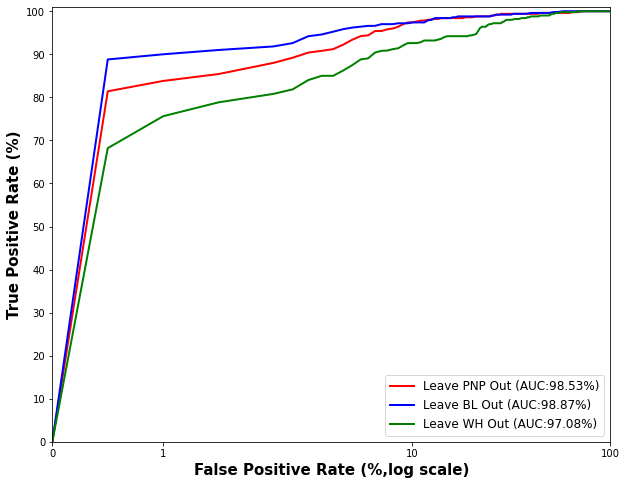

In [23]:
f_res_list = [['taser_leave_pnp_feature_out_cv_result.pkl', 'PNP', 'red'], 
              ['taser_leave_bk_feature_out_cv_result.pkl', 'BL', 'blue'], 
              ['taser_leave_wh_feature_out_cv_result.pkl', 'WH', 'green']]
roc_plot(result_path, f_res_list, [0, 101])

## keep one feature set

In [15]:
# feature selection dict
feature_path = '../data/feature'
feat_dict = {'pnp': ['pnp_feature.txt'],
             'bk':  ['bk_feature.txt'],
             'wh':  ['wh_feature.txt']}

In [16]:
f_tr = '../data/TSS_TA_training_data.csv'
result_path = '../temp/exp_res_pkl'

In [19]:
def taser_keep_one_feat_set_cv(f_data, result_path, max_depth_x=1, n_estimators = 500):
    for k, f_list in feat_dict.items():
        feat_list = ['label']
        print(f'only {k} feature:')
        for f in feat_dict[k]:
            fp_feature_name = os.path.join(feature_path, f)
            with open(fp_feature_name, 'r') as fr:
                feature_names = [line.strip() for line in fr if not line.startswith("#")]    
            feat_list += feature_names
        
        df = pd.read_csv(f_tr, usecols=feat_list)
    
        feature_arr = df.drop(['label'], axis=1).values
        label_arr = df['label'].values
        n_feature = int(feature_arr.shape[1])
        max_depth = int(n_feature * max_depth_x)
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=123)
        res = cv_exp_perform(feature_arr, label_arr, clf)
        
        f_res = os.path.join(result_path, f'taser_with_{k}_feature_cv_result.pkl')
        with open(f_res, 'wb') as f:
            pk.dump(res, f)
        print(res['mean_auc'], res['y_1'])

In [20]:
taser_keep_one_feat_set_cv(f_tr, result_path)

only pnp feature:
cv start
0.9373777575898989 52.400000000000006
only bk feature:
cv start
0.9039866792063352 43.210050251256284
only wh feature:
cv start
0.9785427135678392 71.39999999999999


### ROC curve plot

In [24]:
def roc_plot(result_path, f_res_list, y_lim):
    res = []
    for f in f_res_list:
        fp = os.path.join(result_path, f[0])
        res.append(pk.load(open(fp, 'rb')))

    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.set_xlabel('False Positive Rate (%,log scale)', fontsize=15, weight='bold')
    ax.set_ylabel('True Positive Rate (%)', fontsize=15, weight='bold')
    ax.set(xlim=[0, 100], ylim=y_lim)
    
    for i in range(len(res)):
        ax.plot(res[i]['mean_fpr_100'], 
                res[i]['mean_tpr_100'], 
                color=f_res_list[i][2], 
                label=f"Only {f_res_list[i][1]} Feature (AUC:{round(res[i]['mean_auc']*100,2)}%)", lw=2)
    
    ax.set_xscale('symlog')
    ax.set_xticks([0, 1, 10, 100], minor=False)
    ax.set_xticklabels(['0', '1', '10', '100'], minor=False)
    y_ticks = [y for y in range(y_lim[0], y_lim[1], 10)]
    y_tick_labels = [str(y) for y in range(y_lim[0], y_lim[1], 10)]
    ax.set_yticks(y_ticks, minor=False)
    ax.set_yticklabels(y_tick_labels, minor=True)
    
    ax.legend(loc="best", fontsize='large')

/Users/liujienan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


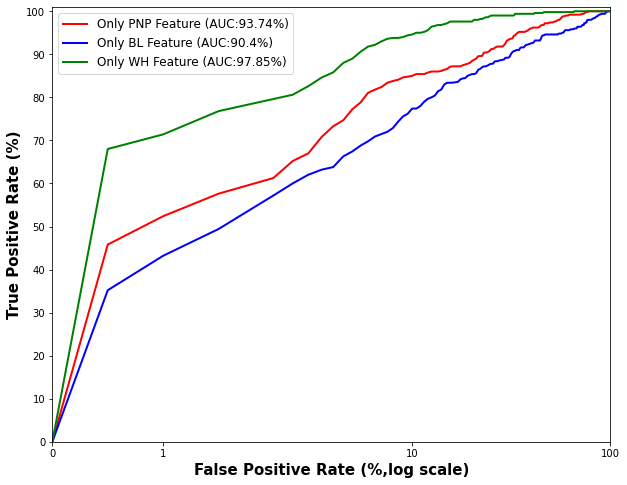

In [25]:
result_path = '../temp/exp_res_pkl'
f_res_list = [['taser_with_pnp_feature_cv_result.pkl', 'PNP', 'red'], 
              ['taser_with_bk_feature_cv_result.pkl', 'BL', 'blue'], 
              ['taser_with_wh_feature_cv_result.pkl', 'WH', 'green']]
roc_plot(result_path, f_res_list, [0, 101])